In [11]:
import pandas as pd
import sys
import numpy as np
import fasttext
import hdbscan
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from collections import defaultdict
import seaborn as sb
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
# from gensim.models.doc2vec import LabeledSentence
# from gensim.models import Doc2Vec
# from gensim.models.doc2vec import TaggedDocument

# Import Dataset

In [12]:
# Import 2019 text dataset
# dfo_1 = pd.read_table('../data/original/2019q1_rr1/txt.tsv')
# dfo_2 = pd.read_table('../data/original/2019q2_rr1/txt.tsv')
# dfo_3 = pd.read_table('../data/original/2019q3_rr1/txt.tsv')
# dfo_4 = pd.read_table('../data/original/2019q4_rr1/txt.tsv')

# dfo = pd.concat([dfo_1,dfo_2,dfo_3,dfo_4])

# Holdings CSV
dfn2 = pd.read_csv('../data/CRSP Mutual Funds - Holdings 2019-01 to 2019-12 with names, ids.csv')


In [13]:
# Text CSV
dfo = pd.read_table('../data/original/2019q4_rr1/txt.tsv')

dfn2 = dfn2[dfn2["Series ID"].isin(dfo.series.unique())]
dfo.dropna(subset=["series"],inplace=True)
dfo = dfo[dfo.series.isin(dfn2["Series ID"].unique())]
dfo_a = dfo[["tag",'series','value']]
dfo_a = dfo_a[dfo_a.tag.isin(['ObjectivePrimaryTextBlock', 'RiskNarrativeTextBlock',  'RiskReturnHeading', 'StrategyNarrativeTextBlock'])]
dfo_a_strategy = dfo_a[dfo_a.tag == 'RiskNarrativeTextBlock'].dropna()
df_corpus = dfo_a_strategy[["series","value"]].drop_duplicates(subset =["value"]).reset_index()
corpus = df_corpus['value'].to_list()
series_find = df_corpus.to_dict()['series']




In [14]:
# Monthly return csv
df_mth = pd.read_csv('../data/monthly/CRSP Mutual Funds - Monthly Returns 2010-01 to 2019-12.csv')

df_lookup = pd.read_csv('../data/CRSP Mutual Funds - Total Lookup - 2019.csv')

df_lu2 = df_lookup[["Series ID","crsp_fundno"]]

df_mth2 = df_mth.merge(df_lu2,how="inner",on = 'crsp_fundno')

df_mth2.caldt = df_mth2.caldt.astype(str).str[:-2]

df_mth2 = df_mth2.replace("R",None)

df_mth2.dropna(subset=["mret"],inplace=True)

c:\program files\python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [38]:
# Lipper Class name csv


df_lip = pd.read_csv("../data/CRSP Mutual Funds - Fund Summary 2010-01 to 2019-12.csv")

df_lip.dropna(subset= ["crsp_obj_cd"],inplace=True)

df_lip = df_lip.drop_duplicates(subset =["crsp_fundno"])

df_lip2 = df_lip[["crsp_fundno","crsp_obj_cd"]]

df_lip3 = df_lip2.merge(df_lu2,how="inner",on = 'crsp_fundno')



# Models

In [17]:
define_model = "BERT"
# Change bert_version to None when not using BERT
bert_version = 'bert-base-nli-mean-tokens'

def embeddings(model,bert_ = None):
    if model == "BERT":
        if bert_ == None :
            embedder = SentenceTransformer('bert-base-nli-mean-tokens')
        else :
#           bert_ = 'bert-base-nli-stsb-mean-tokens'
            embedder = SentenceTransformer(bert_)
        corpus_embeddings = embedder.encode(corpus)
        
    elif model == "tf-idf" :
        vectorizer = TfidfVectorizer(stop_words='english')
        corpus_embeddings = vectorizer.fit_transform(corpus)
    
    elif model == 'doc2vec' :
        labeled_corpus= [TaggedDocument(doc, [str(i)]) for i,doc in enumerate(corpus)]
        model = Doc2Vec(dm = 1, min_count=1, window=10, size=150, sample=1e-4, negative=10)
        model.build_vocab(labeled_corpus)
        model.train(labeled_corpus,epochs=model.iter,total_examples=model.corpus_count)
        corpus_embeddings = []
        for index, row in df_corpus.iterrows():
            corpus_embeddings.append(model.docvecs[index])
    
    return corpus_embeddings

corpus_embeddings = embeddings(define_model,bert_version)

In [18]:
# Bert pre trained models
# bert-base-nli-mean-tokens
# bert-base-nli-max-tokens
# roberta-base-nli-mean-tokens
# distilbert-base-nli-mean-tokens

# bert-base-nli-stsb-mean-tokens
# roberta-large-nli-stsb-mean-tokens
# distilbert-base-nli-stsb-mean-tokens

# K-means Clustering

In [19]:
def elbow(vector):
    sse = {}
    for k in range(10,20):
        kmeans = KMeans(n_clusters=k, max_iter=10000).fit(vector)
        sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.show()
# elbow(corpus_embeddings)

plt.savefig('./plots/elbow.png')

<Figure size 432x288 with 0 Axes>

In [20]:
# choose number of clusters, fit the model
num_clusters = 20
clustering_model = KMeans(n_clusters = num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

In [21]:
# print out the clusters
clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

# for i, cluster in enumerate(clustered_sentences):
#     print("Cluster ", i+1)
#     print(cluster)
#     print("")
#     break

In [22]:
# Get indicies from our clustering
cluster_index = defaultdict(list)
for index,i in enumerate(cluster_assignment) :
    cluster_index[i].append(index)

# Evaluate Clustering Model

In [23]:
if 'buckets' not in locals():
    buckets = {}
    count = 0
    size_dfn = len(dfn2["Series ID"].unique())
    for i in dfn2["Series ID"].unique():
        count+=1
        if count % 100  == 0 :
            print(count,'/',size_dfn)

        buckets[i] = set(dfn2[dfn2["Series ID"] == i].cusip)

100 / 1006
200 / 1006
300 / 1006
400 / 1006
500 / 1006
600 / 1006
700 / 1006
800 / 1006
900 / 1006
1000 / 1006


In [24]:
# Evaluate clustering based on portfolio. Good Clustering model will show that they have common stock holdings

def metric(fund1,fund2):
    bucket1 = buckets[fund1]
    bucket2 = buckets[fund2]
    
    bucket1_size = len(bucket1)
    bucket2_size = len(bucket2)
    
    if bucket1_size == 0 or bucket2_size == 0 :
        return 'no stocks in fund'
    
    common_stocks = len(bucket1.intersection(bucket2)) 
#   score = common_stocks
    score = (common_stocks/bucket1_size + common_stocks/bucket2_size)/2
    
    return score

In [25]:
# Get the series ID for each clusters
cluster_seriesid = {}

for cluster in range(num_clusters):
    cluster_size = len(cluster_index[cluster])
    print('Cluster_{} size'.format(cluster),cluster_size)
    cluster_seriesid[cluster] = [series_find[cluster_index[cluster][i]] for i in range(cluster_size)]

Cluster_0 size 88
Cluster_1 size 51
Cluster_2 size 64
Cluster_3 size 53
Cluster_4 size 50
Cluster_5 size 53
Cluster_6 size 43
Cluster_7 size 48
Cluster_8 size 74
Cluster_9 size 10
Cluster_10 size 16
Cluster_11 size 1
Cluster_12 size 53
Cluster_13 size 23
Cluster_14 size 11
Cluster_15 size 34
Cluster_16 size 12
Cluster_17 size 40
Cluster_18 size 23
Cluster_19 size 28


In [26]:
# Get within value

within_score = 0
count = 0

for cluster in range(num_clusters):
    
    for fund1 in cluster_seriesid[cluster] :
        for fund2 in cluster_seriesid[cluster] :
            if fund1 == fund2 :
                continue
            count += 1
            score = metric(fund1,fund2)
            within_score += score 
            

final_within_score = round(within_score/count,4)

print(final_within_score)

0.0996


In [27]:
# Get random sample value
random_sample_score = 0
count = 0

np.random.seed(100)

for cluster in range(num_clusters):
    size = len(cluster_seriesid[cluster])
    random_sample = np.random.choice(dfn2["Series ID"].unique(),size,replace=False)
    
    for fund1 in cluster_seriesid[cluster] :
        for fund2 in random_sample :
            count += 1
            score = metric(fund1,fund2)
            random_sample_score += score 
            

final_random_score = round(random_sample_score/count,4)

print(final_random_score)

0.0934


In [28]:


result = pd.Series([define_model,bert_version,"Clustering Score",final_within_score,"Benchmark",final_random_score])

result.to_csv(r'./result_{}_{}.txt'.format(define_model,bert_version), header=None, index=None)


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


# Get the Lipper Class distribution for each cluster

In [29]:
df_lip3[df_lip3["Series ID"].isin(cluster_seriesid[cluster])].copy()

,crsp_fundno,crsp_obj_cd,Series ID
193208,51172,EFRP,S000030491
193209,51172,EFRP,S000030491
193210,51172,EFRP,S000030491
193211,51172,EFRP,S000030491
193212,51172,EFRP,S000030491
...,...,...,...
267280,94836,M,S000063425
267281,94836,M,S000063425
267282,94836,M,S000063425
267960,95706,I,S000065590


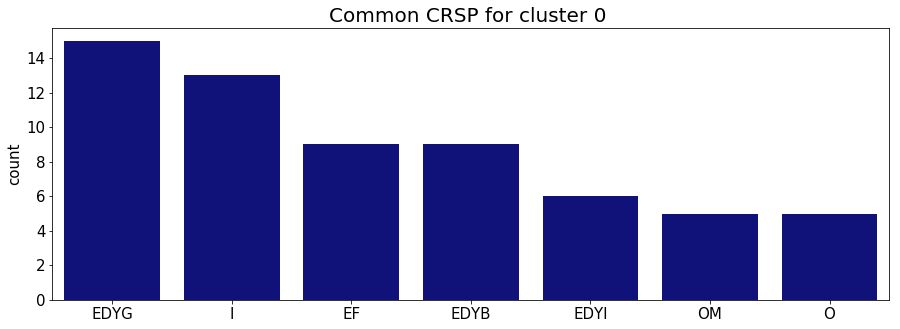

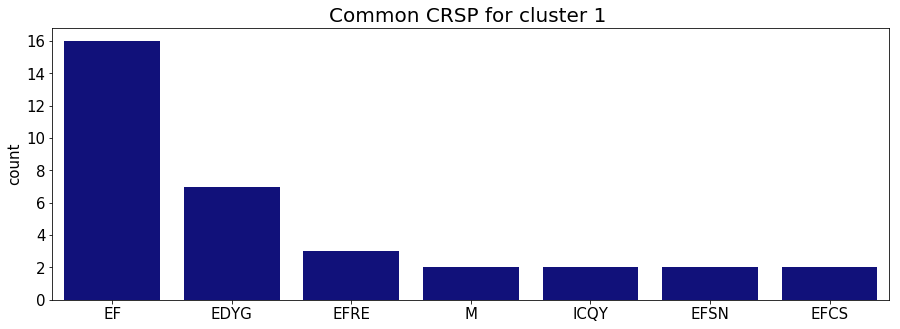

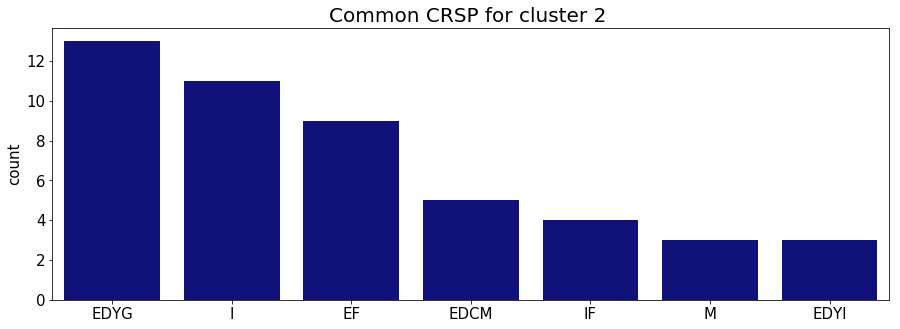

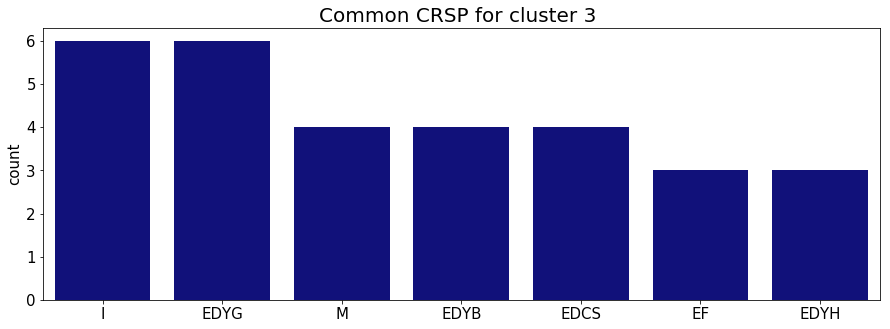

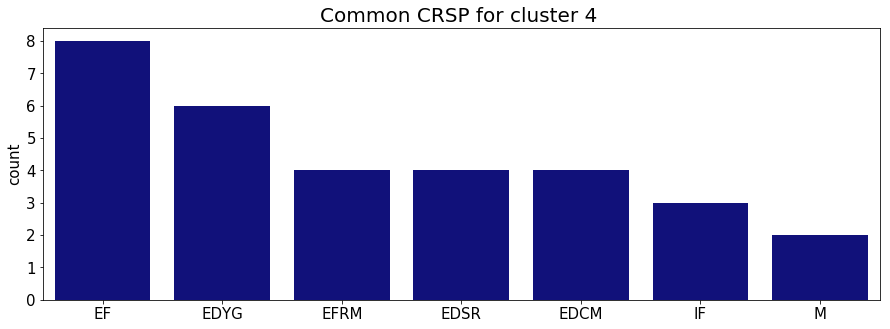

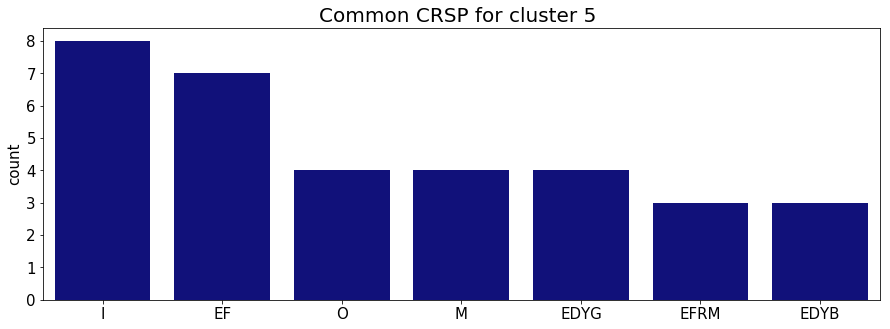

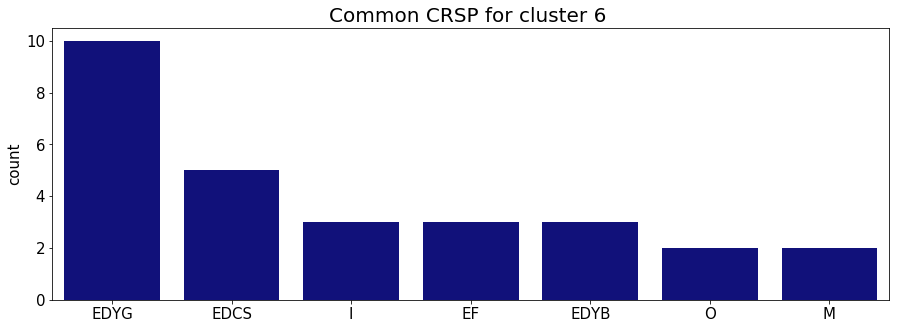

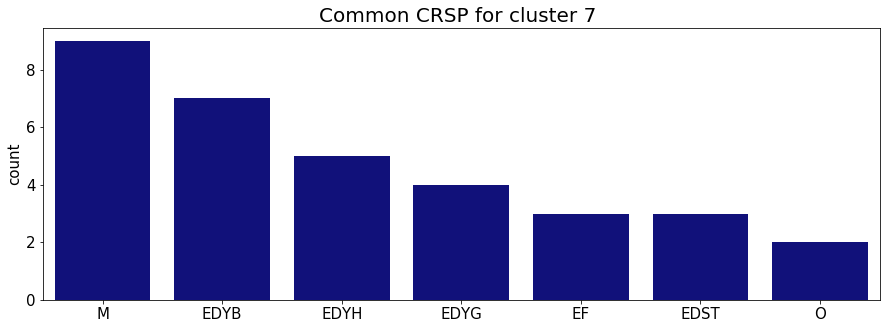

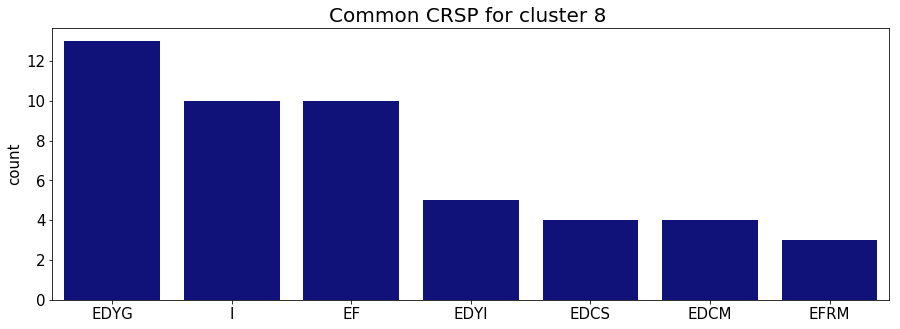

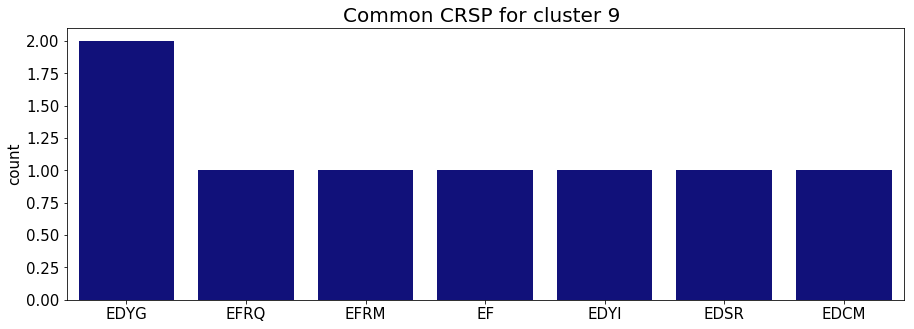

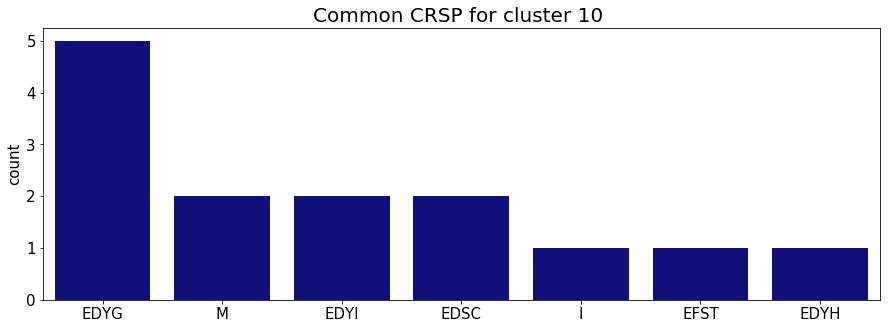

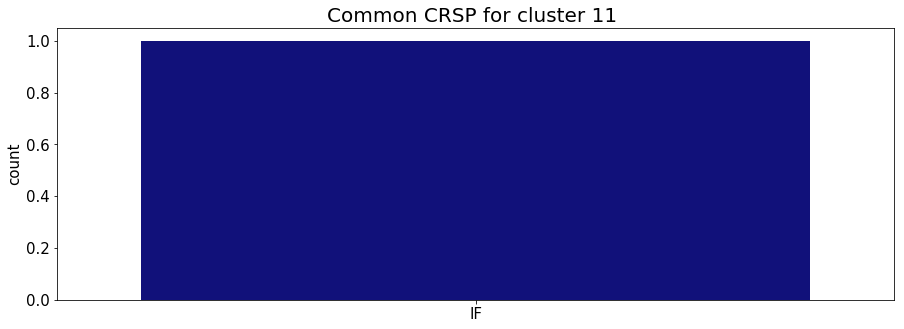

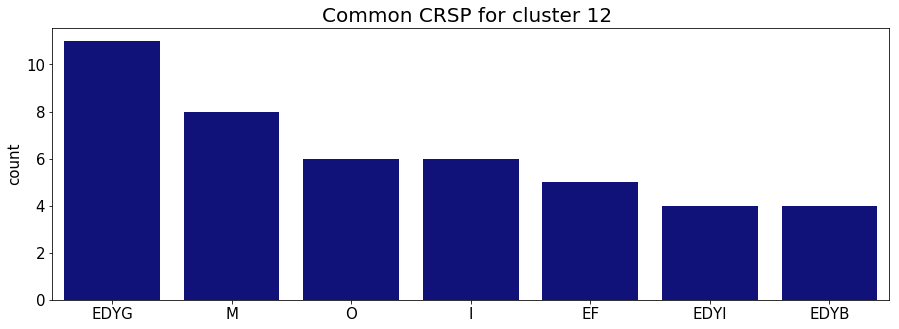

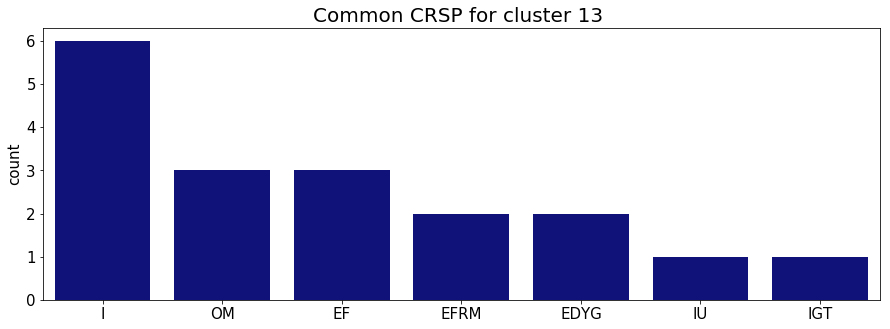

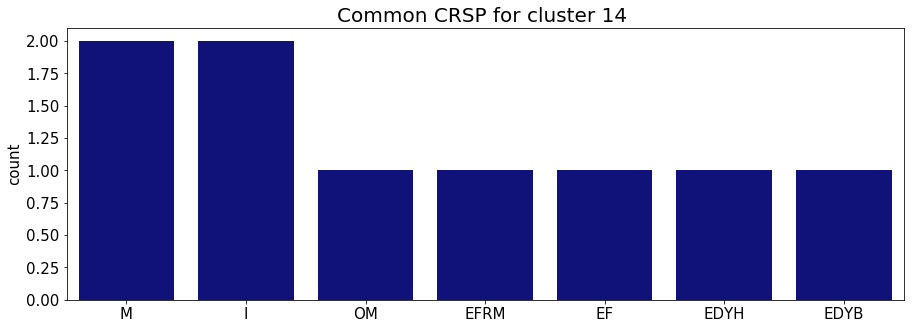

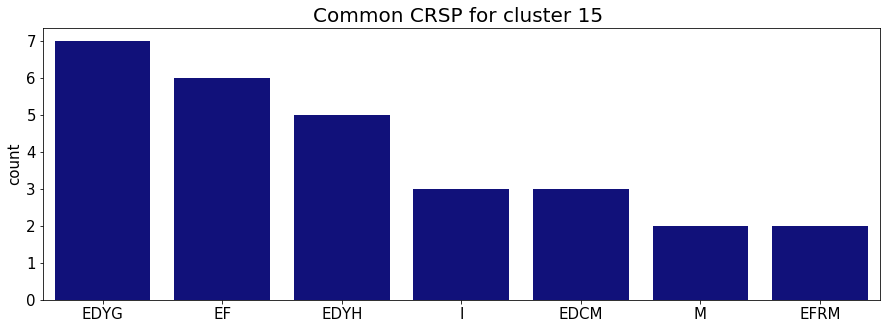

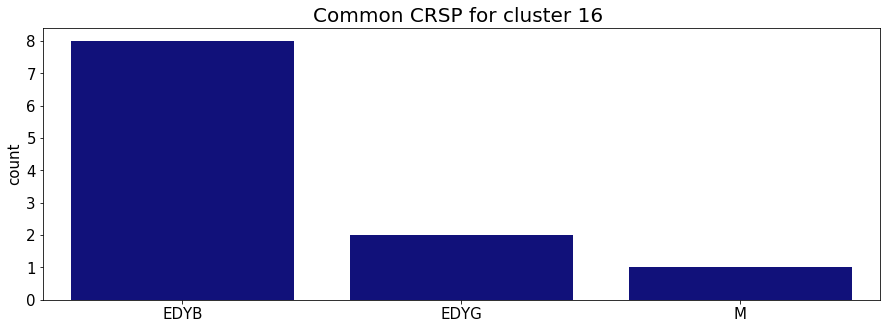

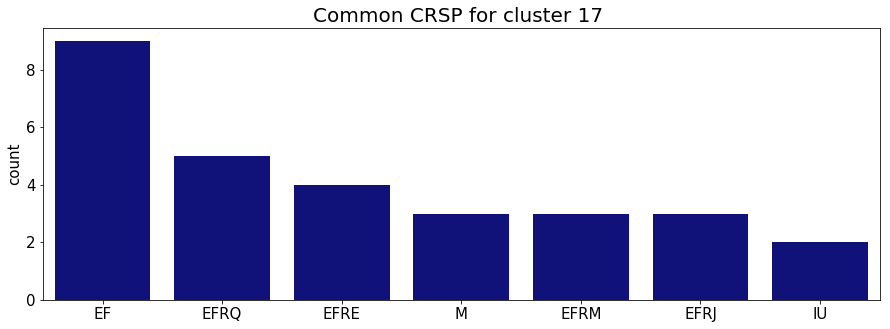

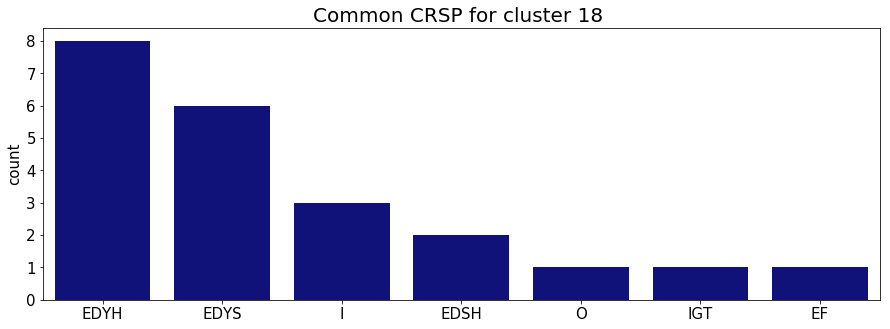

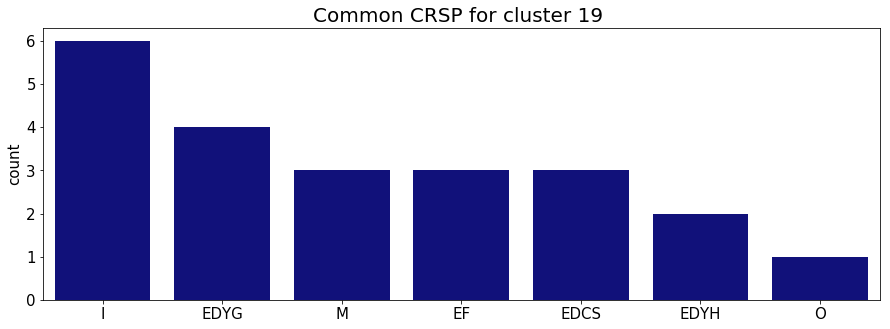

In [39]:
def lipper(cluster):
    
    df_lip4 = df_lip3[df_lip3["Series ID"].isin(cluster_seriesid[cluster])].copy()
    
    arr_slice = df_lip4["crsp_obj_cd"].values

    # Get unique IDs corresponding to each linear index (i.e. group) and grouped counts
    unq,unqtags,counts = np.unique(arr_slice,return_inverse=True,return_counts=True)

    count_dict = dict(zip(unq, counts))
    
    sorted_dict = sorted(count_dict.items(), key = 
             lambda kv:(kv[1] , kv[0]),reverse=True)[:7]
    
    dfdf = pd.DataFrame({"lipper_class": [i for i,_ in sorted_dict],"count":[j for _,j in sorted_dict]})
    
    plt.figure(figsize = (15,5))
    splot = sb.barplot(x='lipper_class',y='count',data=dfdf,color="darkblue")
    plt.title("Common CRSP for cluster {} ".format(cluster),fontsize = 20)
    plt.xticks(fontsize=15)
    plt.xlabel("")
    plt.ylabel("count",fontsize=15)
    plt.tick_params(labelsize=15)

for i in range(num_clusters):
    lipper(i)
    plt.savefig("./plots/lipper/lipper_class_cluster{}".format(i))
    


# Get the Top 5 most Common Stocks for each Cluster




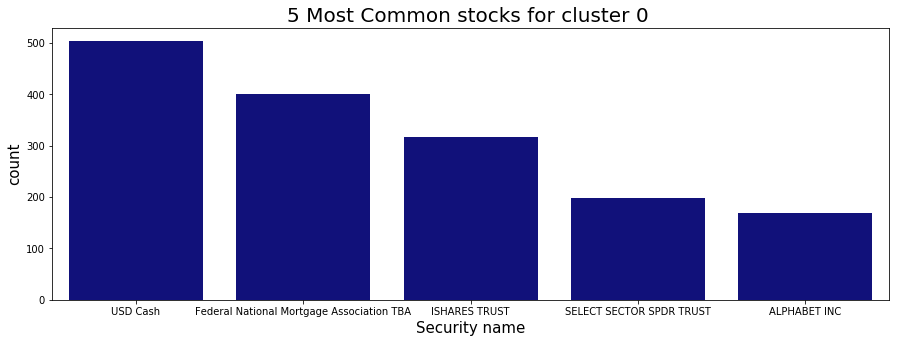

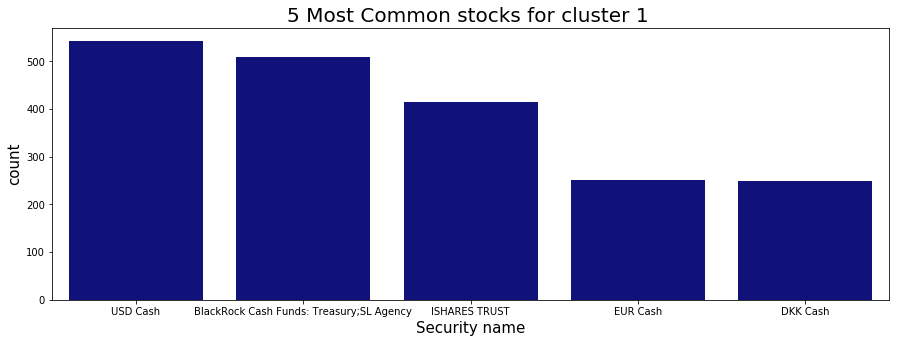

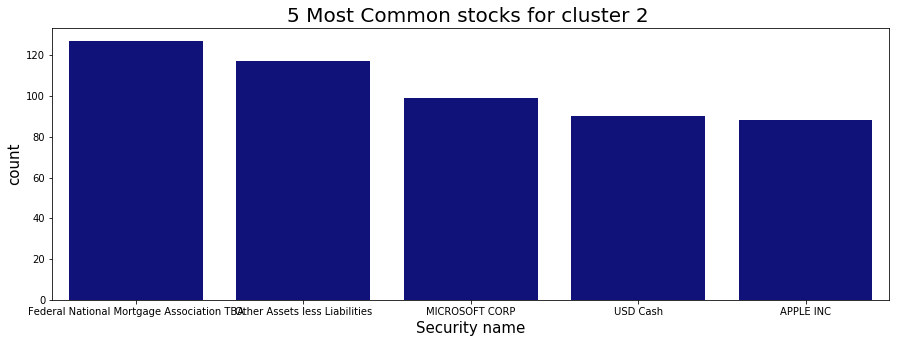

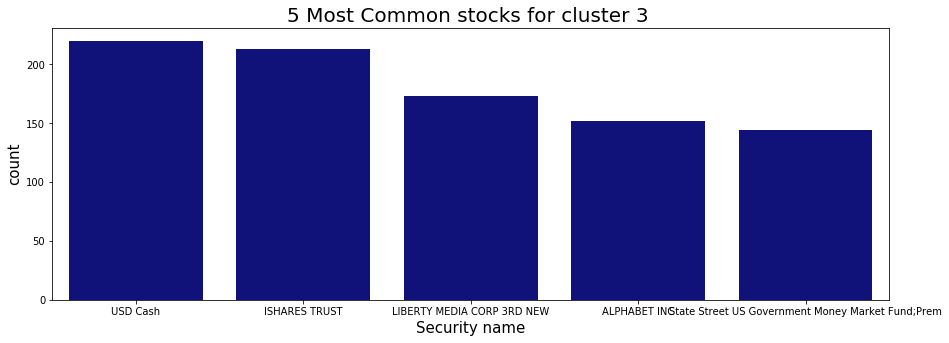

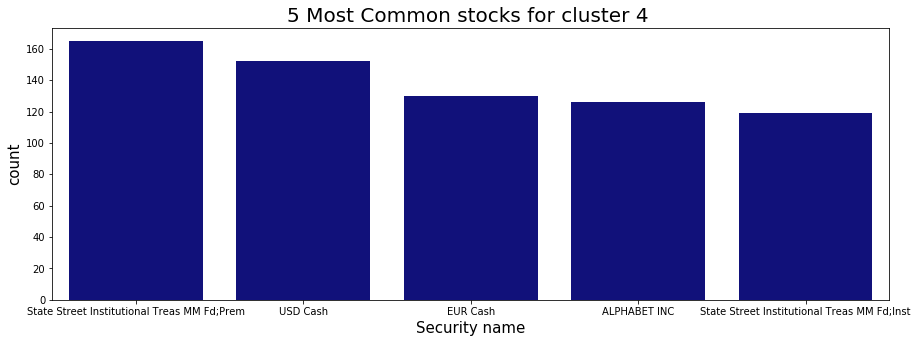

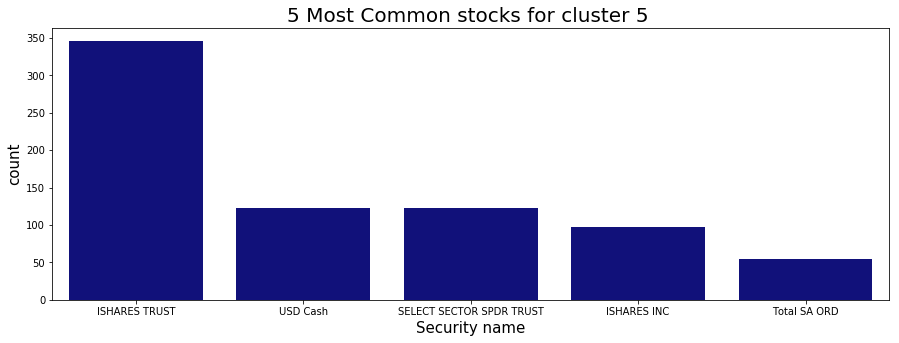

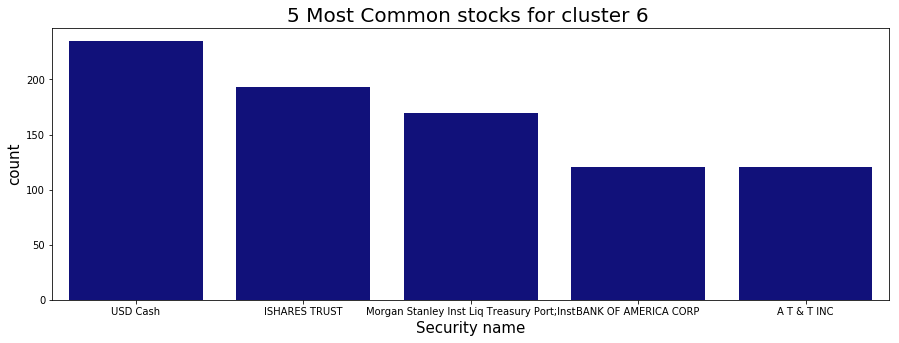

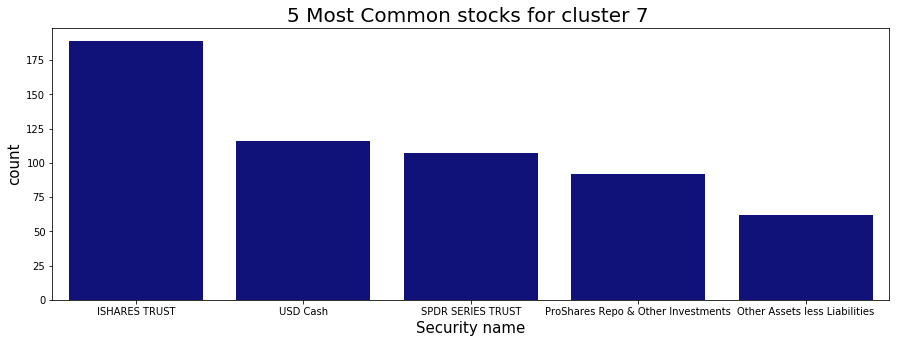

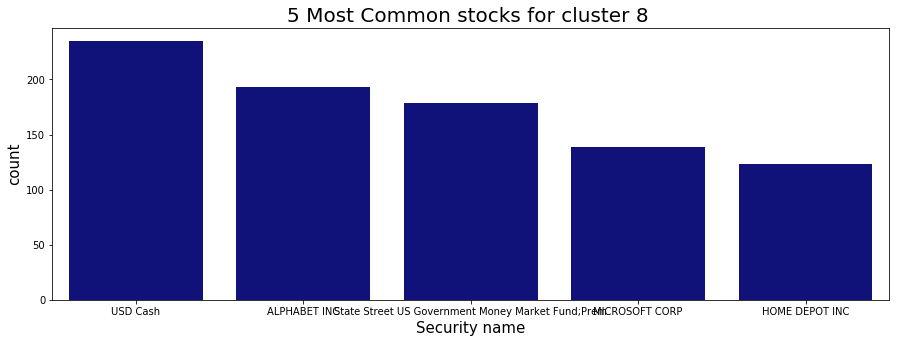

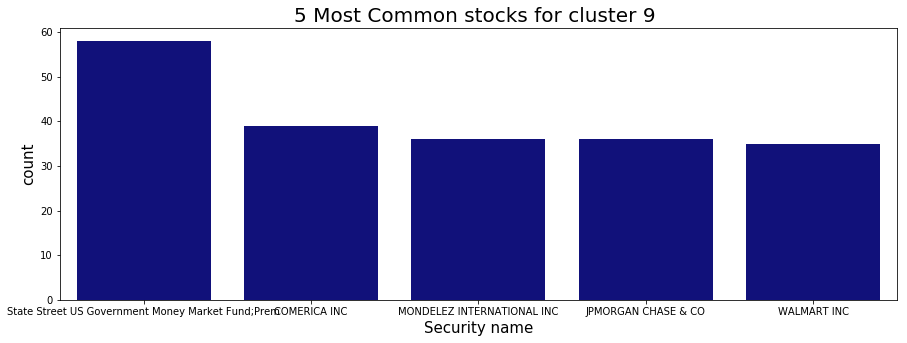

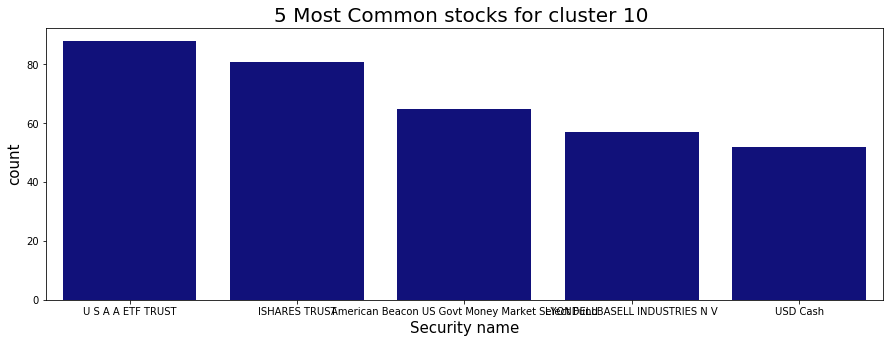

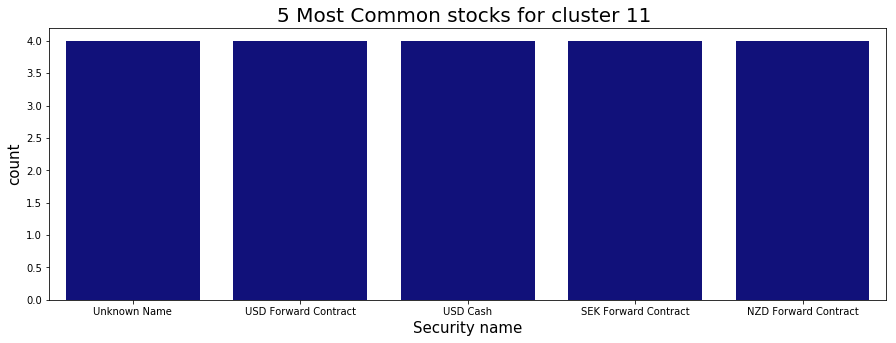

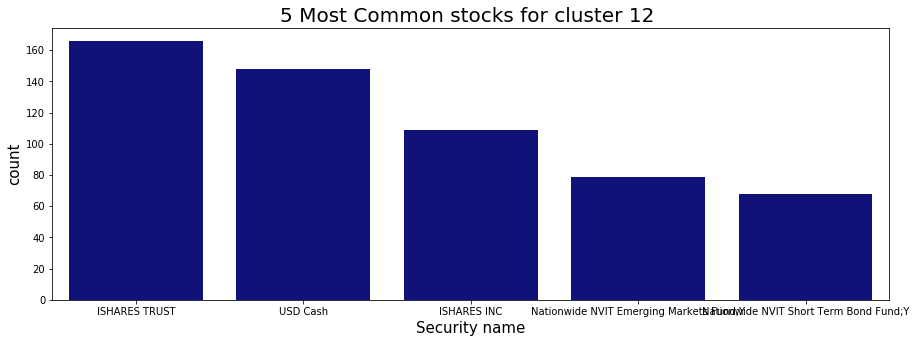

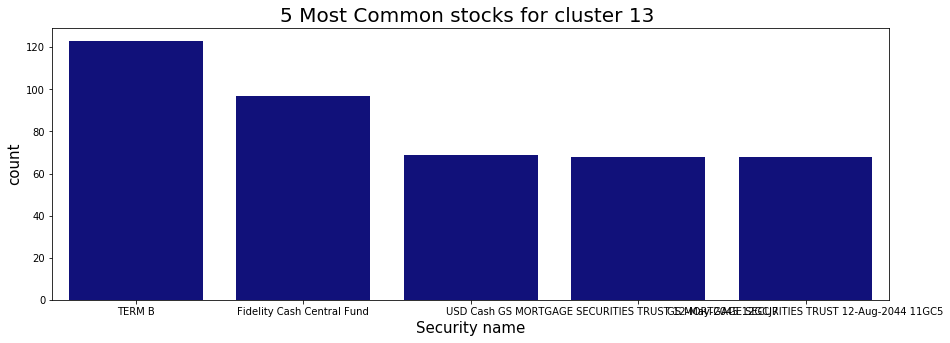

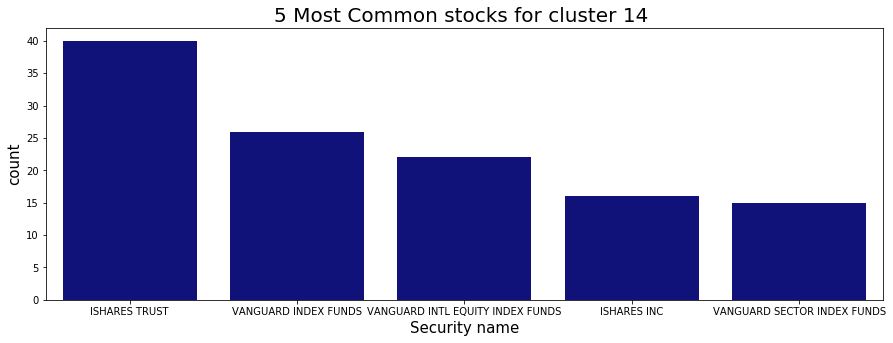

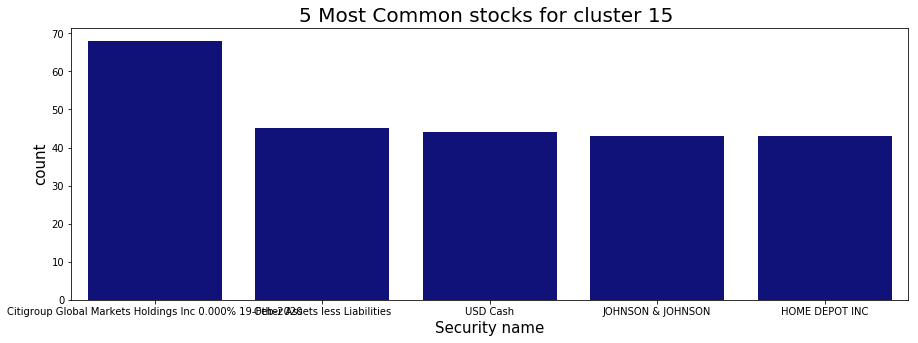

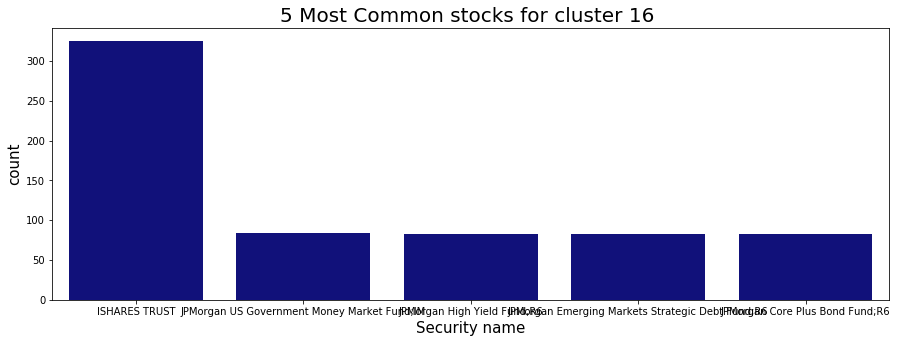

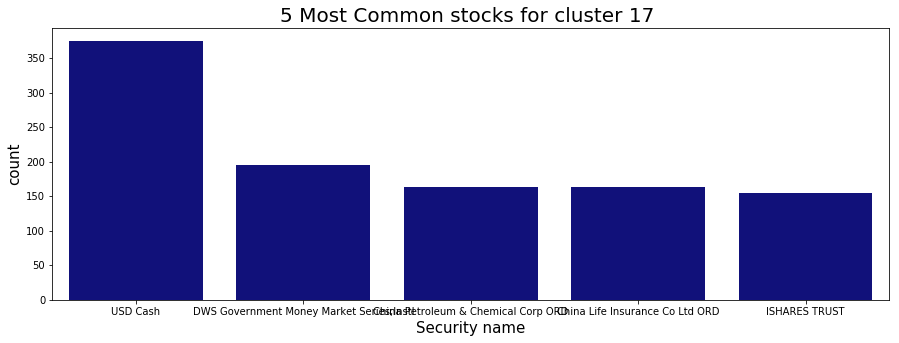

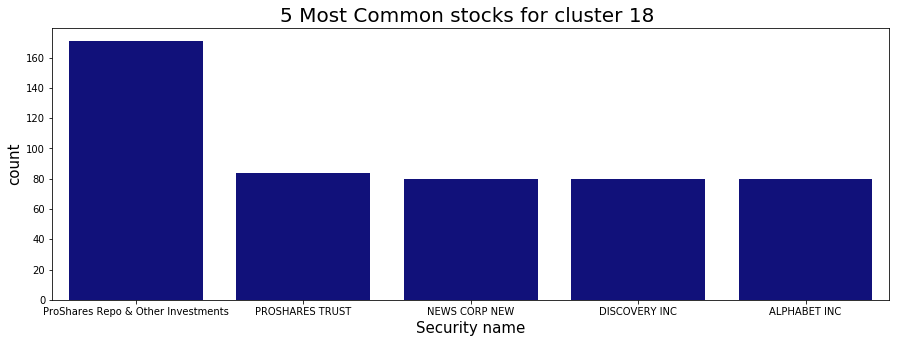

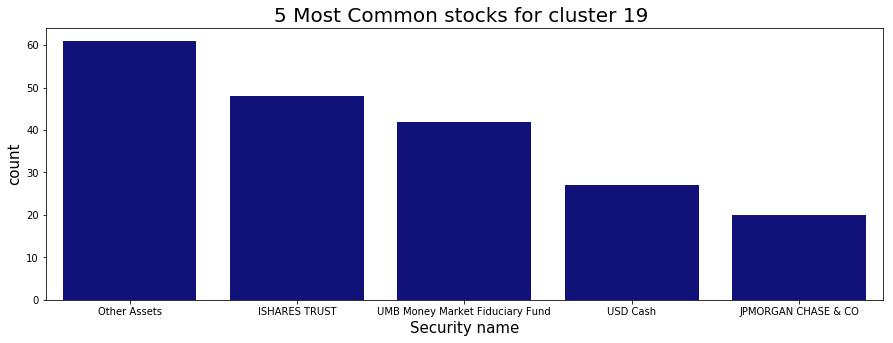

In [31]:
def cs_graph(cluster) :
    stock_bucket = []
    df_temp = dfn2[["Series ID","security_name"]].copy()
    df_temp = df_temp[df_temp["Series ID"].isin(cluster_seriesid[cluster])]
    
    arr_slice = df_temp["security_name"].values

    # Get unique IDs corresponding to each linear index (i.e. group) and grouped counts
    unq,unqtags,counts = np.unique(arr_slice,return_inverse=True,return_counts=True)

    count_dict = dict(zip(unq, counts))
    
    sorted_dict = sorted(count_dict.items(), key = 
             lambda kv:(kv[1] , kv[0]),reverse=True)[:5]
    
    dfdf = pd.DataFrame({"security_name": [i for i,_ in sorted_dict],"count":[j for _,j in sorted_dict]})
    
    plt.figure(figsize = (15,5))
    splot = sb.barplot(x='security_name',y='count',data=dfdf,color="darkblue")
    plt.title("5 Most Common stocks for cluster {} ".format(cluster),fontsize = 20)
    plt.xlabel("Security name", fontsize=15)
    plt.ylabel("count",fontsize=15)
    plt.xticks(fontsize=10)
    
for i in range(num_clusters):
    cs_graph(i)
    plt.savefig('./plots/common_stocks/Common_stocks_cluster{}'.format(i))


# Get Common Words for each Cluster using bag of words

In [32]:
# Get bag of words for cluster
def bag_of_words(cluster):
    corpus_2 = clustered_sentences[cluster]
    vec = CountVectorizer().fit(corpus_2)
    bag_of_words = vec.transform(corpus_2)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq

# Examine Average Monthly/Annual Return for each Cluster 

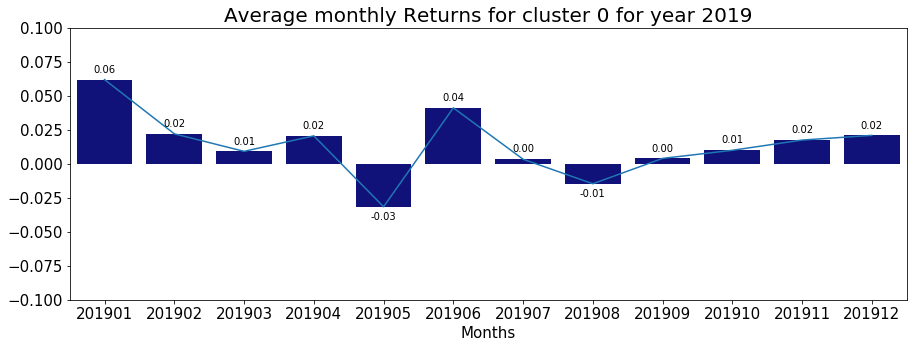

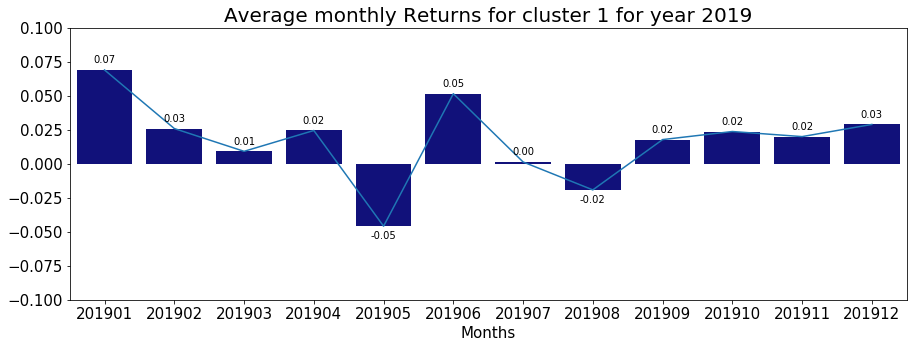

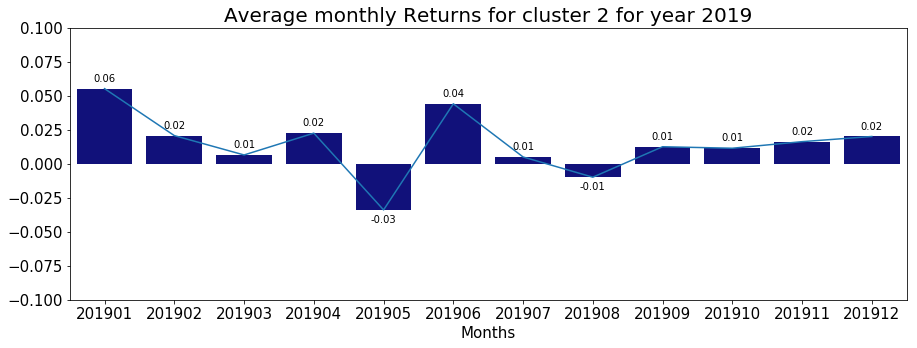

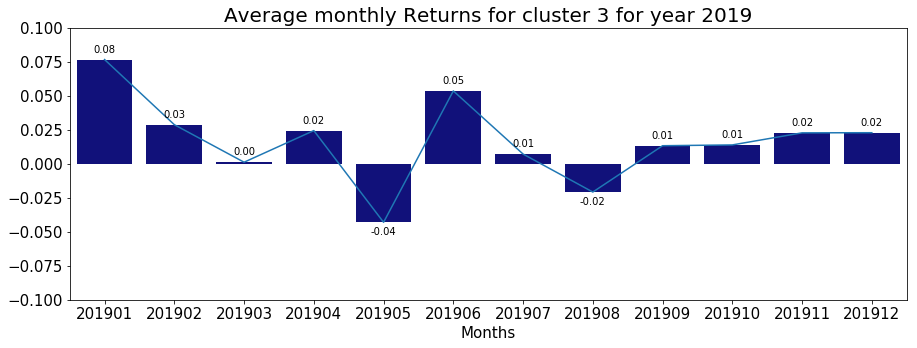

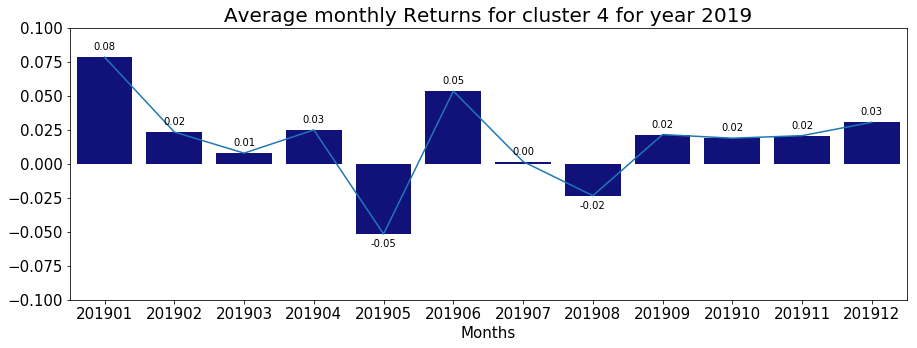

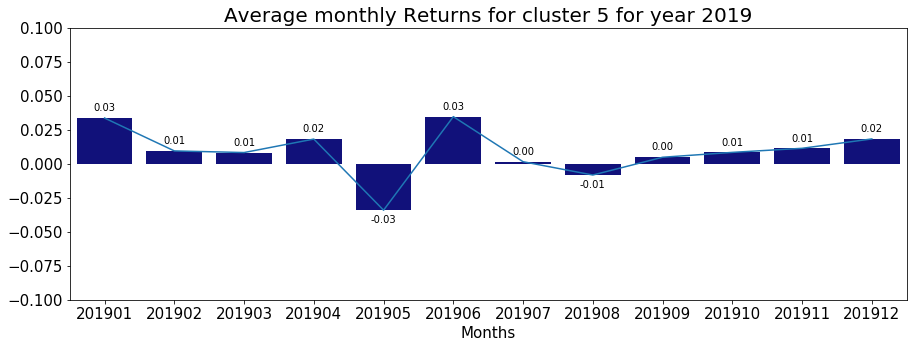

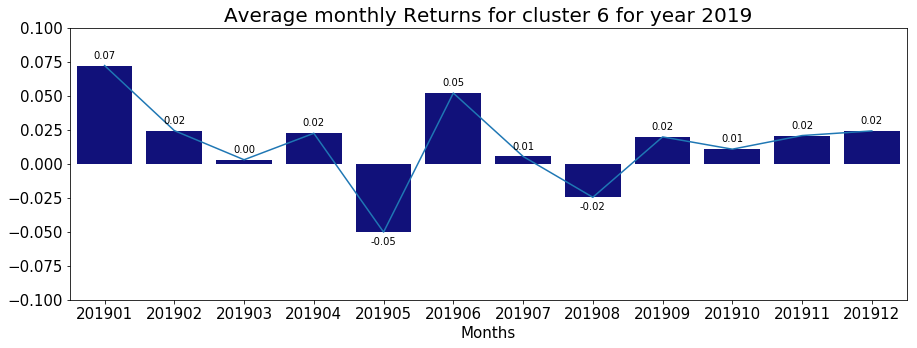

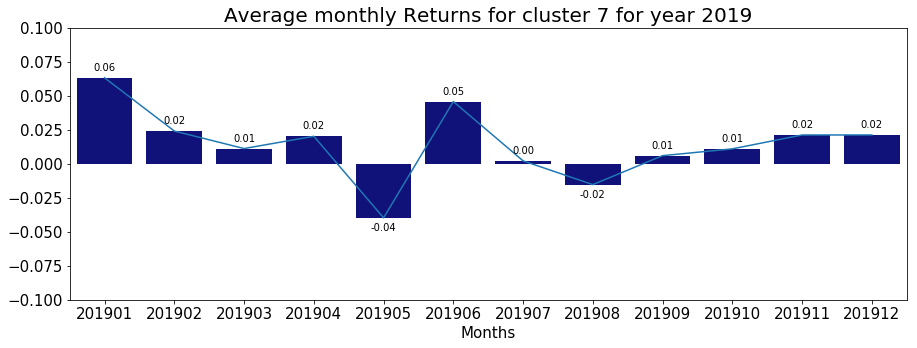

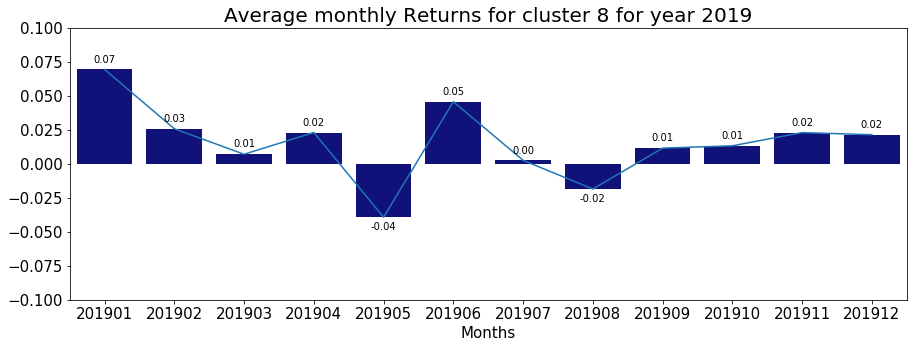

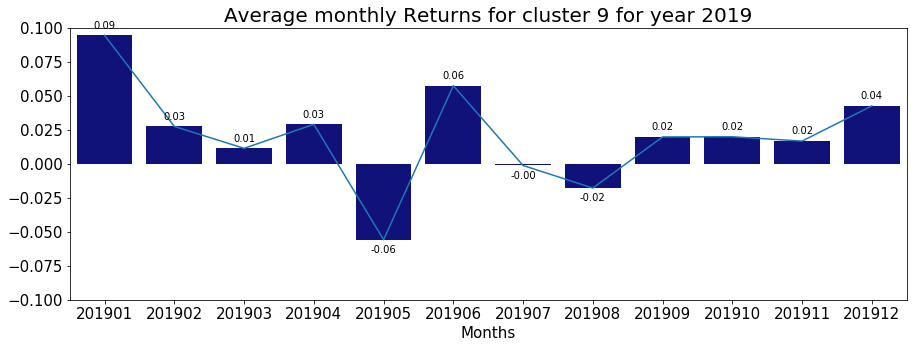

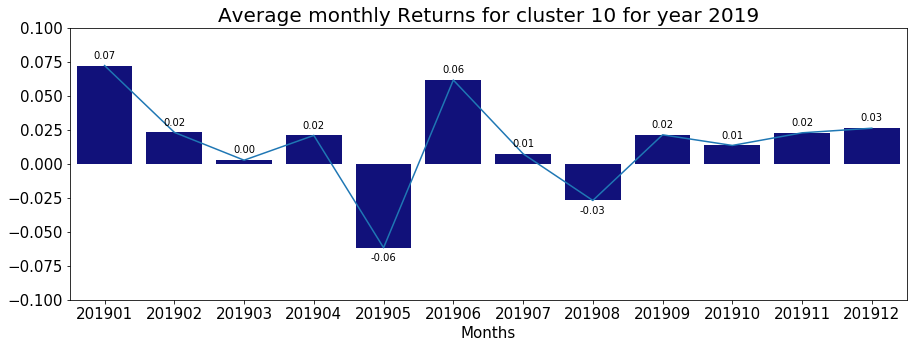

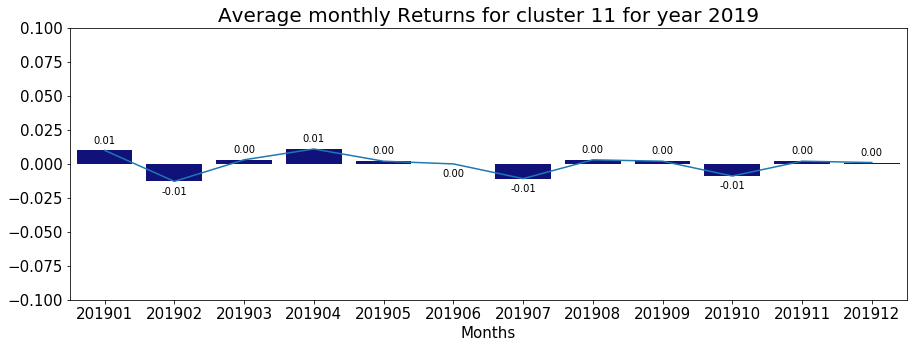

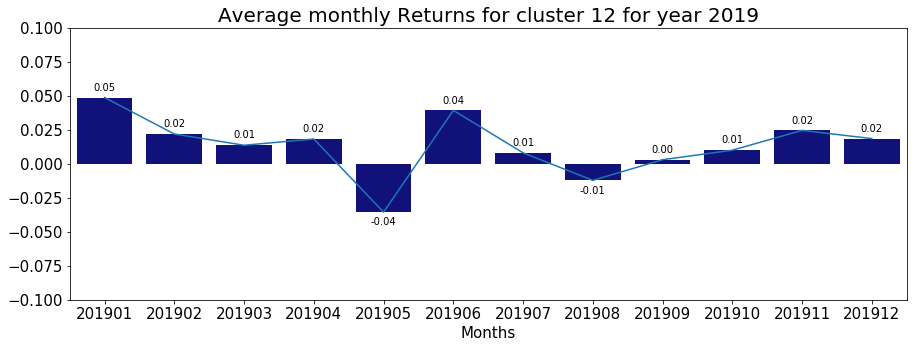

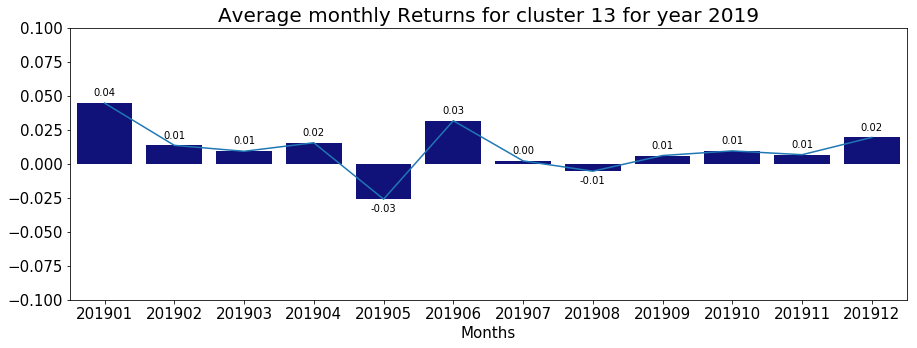

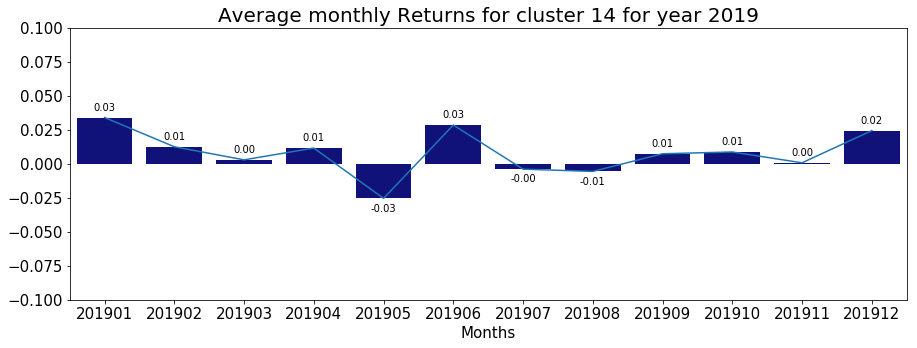

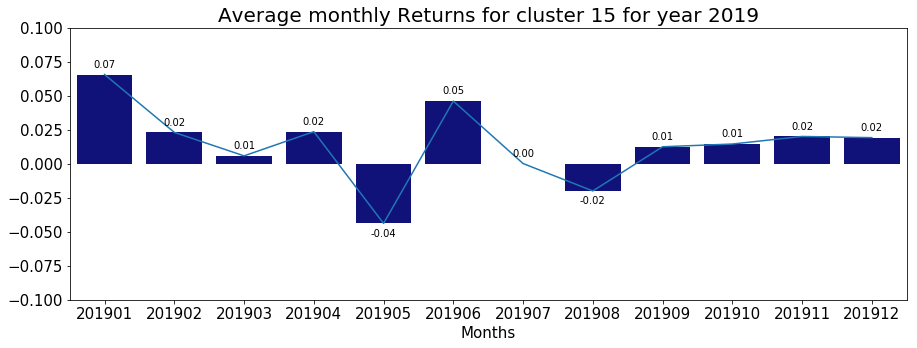

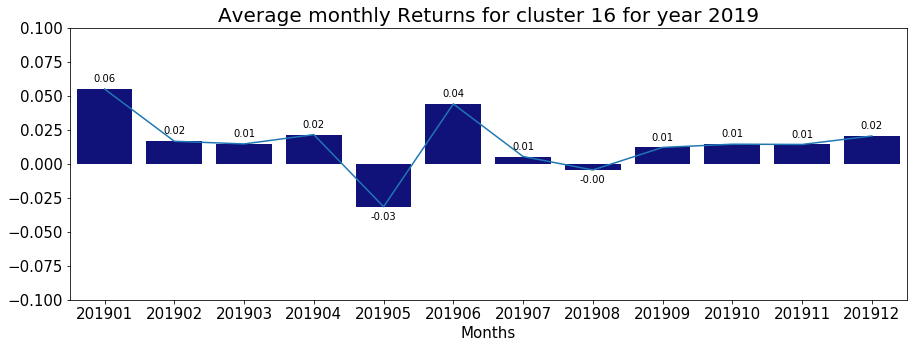

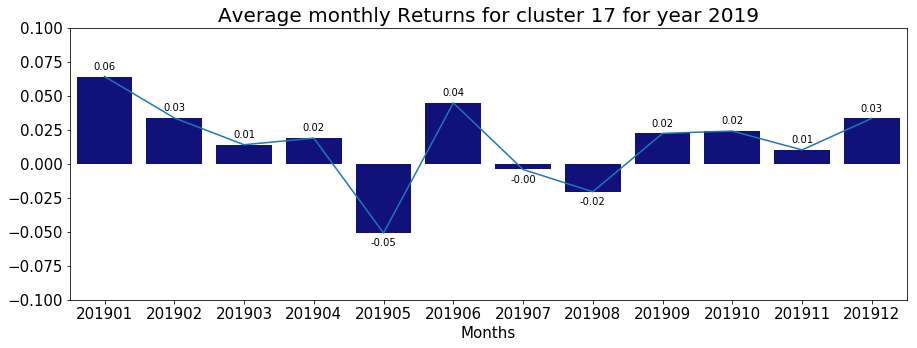

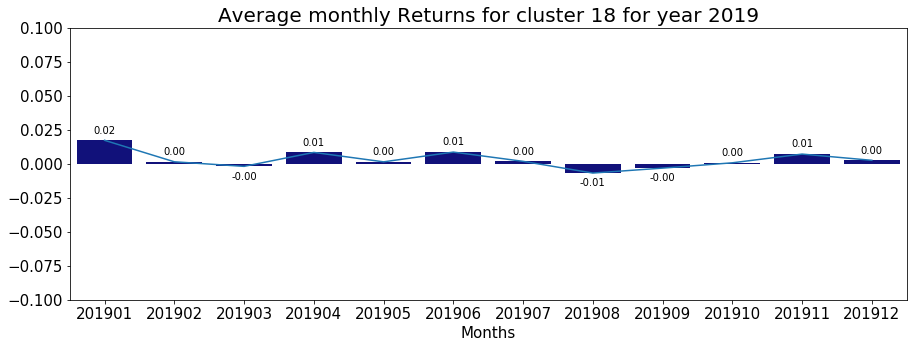

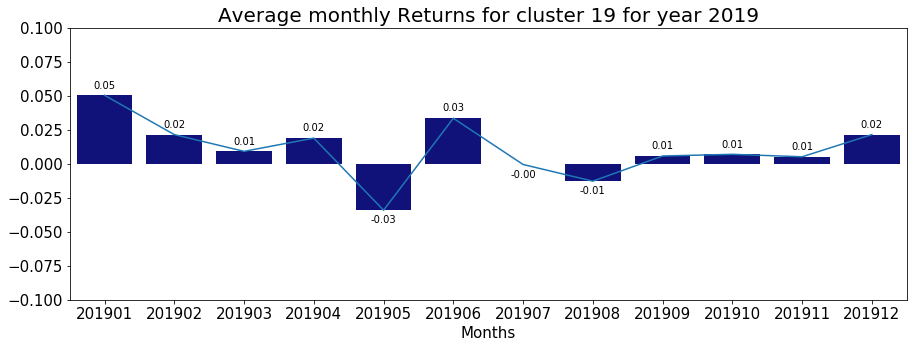

In [33]:
# Based on our clustering get the monthly return for each cluster


# Line/Bar Graph for all values
def return_graph(cluster,year):
    
    df_mth_19 = df_mth2[df_mth2.caldt.str[:4] == year]
    
    cluster_series_id = cluster_seriesid[cluster]
    
    df_mth_filt = df_mth_19[df_mth_19["Series ID"].isin(cluster_series_id)].copy()
    df_mth_filt.mret = df_mth_filt.mret.astype(float)

    
    graph_df = df_mth_filt.groupby("caldt").mean().reset_index()[['caldt','mret']]
    graph_df.columns = ["Returns",'Value']
    
    plt.figure(figsize=(15,5))
    line_plot = sb.lineplot(x='Returns',y='Value',data=graph_df)
    splot = sb.barplot(x='Returns',y='Value',data=graph_df,color="darkblue")
    plt.title('Average monthly Returns for cluster {} for year {}'.format(cluster,year),fontsize=20)
    plt.tick_params(labelsize=15)
    plt.xlabel("Months",fontsize=15)
    plt.ylabel("")
    plt.ylim(-0.1, 0.1)
    for p in splot.patches:
        if p.get_height() > 0:
            splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
        else :
            splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, -10), textcoords = 'offset points')

for i in range(num_clusters):
    return_graph(i,'2019')
    plt.savefig('./plots/monthly/monthly_return_cluster{}.png'.format(i))
    
    
    

In [34]:
# Based on our clustering get the annual return for each cluster
column_lists = ['AnnualReturn2008','AnnualReturn2009', 'AnnualReturn2010', 'AnnualReturn2011',
       'AnnualReturn2012', 'AnnualReturn2013', 'AnnualReturn2014',
       'AnnualReturn2015', 'AnnualReturn2016', 'AnnualReturn2017',
       'AnnualReturn2018']

dataframe = {}
dataframe_embeddings = {}
cluster_adsh = {}

for cluster in range(num_clusters):
    dataframe[cluster] = {}
    
    df_temp = df[df.adsh.isin(cluster_adsh[cluster])]
    
    dataframe[cluster] = df_temp[df_temp.tag.isin(column_lists)][['Series ID','tag','rate']]

NameError: name 'df' is not defined

In [ ]:
# Line/Bar Graph for all values
def return_graph(cluster):
    
    df_return = dataframe[cluster].groupby('tag').mean().reset_index()
    df_return.columns = ['Returns','Value']
    df_return.Returns = df_return.Returns.str.strip('AnnualReturn')
    plt.figure(figsize=(11,7))
    line_plot = sb.lineplot(x='Returns',y='Value',data=df_return)
    splot = sb.barplot(x='Returns',y='Value',data=df_return,color="darkblue")
    plt.title('Average Annual Returns for cluster {}'.format(cluster))
    plt.ylim(-0.5, 0.5)
    for p in splot.patches:
        if p.get_height() > 0:
            splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
        else :
            splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, -10), textcoords = 'offset points')

for i in range(num_clusters):
    return_graph(i)
    plt.savefig('./plots/Annual/Annual_return cluster{}.png'.format(i))

    

In [ ]:
# using average values, it is hard to see if our clustering is doing well.
# let's see the distribution of annual return 2018

In [ ]:
# Distribution(histogram) Graph for one year

def return_graph_year(year,cluster):
#     global df_return_year
    df_return_year = dataframe[cluster][dataframe[cluster].tag == 'AnnualReturn'+str(year)].rate.dropna()
    plt.figure(figsize=(10,5))
    sb.distplot(df_return_year)
    plt.title('cluster {} / Average :  {} / Std : {}'.format(cluster,str(round(df_return_year.mean(),2)),str(round(df_return_year.std(),2))))

for i in range(num_clusters):
    return_graph_year(2018,i)
    plt.savefig('./plots/distribution/Return_distribution_cluster {}.png'.format(i))


# Compare Return within/between Distances

In [ ]:

pivot_df = {}
pivot_df2 = {}
for i in range(num_clusters):
    pivot_df[i] = dataframe[i].pivot(index='adsh', columns='tag', values='rate')
    temp = pivot_df[i].drop('AnnualReturn2008',axis=1)
    pivot_df2[i] = temp.fillna(temp.mean())

In [ ]:
# emb_dist = {}
emb_dist_valid = defaultdict(list)
ret_dist = defaultdict(list)
for i in range(num_clusters) :
#     emb_dist[i] = clustering_model.transform(dataframe_embeddings[i]).mean(axis=0)
 
    for j in range(num_clusters) :
        ret_dist[i].append(euclidean_distances(pivot_df2[i],pivot_df2[j]).mean())
        emb_dist_valid[i].append(euclidean_distances(dataframe_embeddings[i],dataframe_embeddings[j]).mean())

In [ ]:
# Cluster within distance/between distance - Return values
return_distance = pd.DataFrame(ret_dist)

return_distance.columns = ['cluster ' + str(i) for i in return_distance.columns]
return_distance.index = return_distance.columns

print('The max distance value for\n -------- is  --------')
return_distance.idxmax(axis = 0) 

In [ ]:
return_distance

In [ ]:
# Cluster within distance/between distance - Original embedding values

embedding_distance = pd.DataFrame(emb_dist_valid)

embedding_distance.columns = ['cluster ' + str(i) for i in embedding_distance.columns]
embedding_distance.index = embedding_distance.columns

print('The max distance value for\n -------- is  --------')
embedding_distance.idxmax(axis = 0) 

In [ ]:
embedding_distance